# [Demo] Bayesian filters: vehicle tracking

Wouter Kouw | Last update: 31-05-2022

We will be tracking a driving car based on noisy position observations. You can find this example in [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67) by Simon Särkkä (Ex 3.6). 

## System

Consider a discrete-time dynamical system with noisy observations $y_k \in \mathbb{R}^{d_y}$ and latent states $x_k \in \mathbb{R}^{d_x}$. We can express the dynamics in the form of a state-space model:

$$\begin{align}
x_k =&\ Ax_{k-1} + q_{k-1} \\
y_k =&\ Cx_k + r_{k} \, ,
\end{align}$$

where $A$ is a state transition matrix, $C$ is an observation emission matrix, $q_{k-1}$ represents process noise and $r_{k}$ is measurement noise. Both sources of noise are Gaussian distributed with zero mean:

$$q_{k-1} \sim \mathcal{N}(0, Q) \, , \qquad r_k \sim \mathcal{N}(0, R) \, ,$$

with covariance matrices $Q$ and $R$.

The state transition has the following form:

$$\begin{align*}
\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix}}_{x_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ x_{3,k-1} \\ x_{4,k-1} \end{bmatrix}}_{x_{k-1}} + q_{k-1}
\end{align*}$$

where $x_1$ and $x_2$ represent the 2-D position of the car and $x_3$ and $x_4$ represent its velocity. 

The measurement function is described as:

$$\begin{align*}
\underbrace{\begin{bmatrix} y_{1,k} \\ y_{2,k} \end{bmatrix}}_{y_k} = \underbrace{\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}}_{C} \begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix} + r_k
\end{align*}$$

We only get the noisy observations of the position of the car, but not its velocity.

In [1]:
using LinearAlgebra
using ProgressMeter
using Plots
default(label="", grid=false, margin=20Plots.pt)

In [2]:
include("../kalman_filters.jl")

students_t_filter (generic function with 1 method)

In [3]:
# Length of time-series
T = 100
Δt = 0.1

# Dimensionalities
Dx = 4
Dy = 2

# Transition matrix
A = [1 0 Δt 0;
     0 1 0 Δt;
     0 0 1 0;
     0 0 0 1];

# Emission matrix
C = [1 0 0 0;
     0 1 0 0];

# Process noise covariance
qc = 0.1
Q = qc.*[Δt^3/3       0   Δt^2/2       0;
              0  Δt^3/3        0  Δt^2/2;
         Δt^2/2       0       Δt       0;
              0  Δt^2/2        0      Δt];
    
# Measurement noise variance  
rc = 0.01
R = rc.*Matrix{Float64}(I,2,2)
     
# Initial states
state_0 = [0., 0., 1., -1.]

# Initialize data array
states = zeros(Dx,T)
observations = zeros(Dy,T)

# Initialize previous state variable
prev_state = state_0

for k = 1:T
    
    # State transition
    states[:,k] = A*prev_state + cholesky(Q).L*randn(Dx)
    
    # Observation with added measurement noise
    observations[:,k] = C*states[:,k] + cholesky(R).L*randn(Dy)
    
    # Update "previous state"
    prev_state = states[:,k]
    
end    

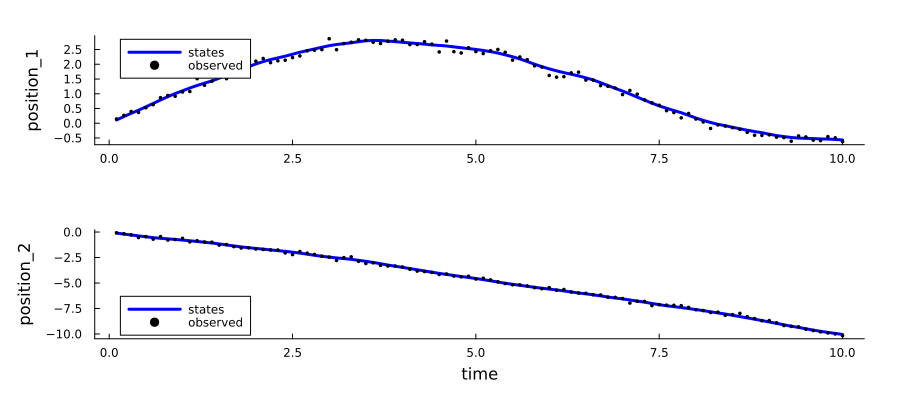

In [4]:
# Inspect data
p1 = plot((1:T).*Δt, states[1,:], linewidth=3, color="blue", xlabel="", ylabel="position_1", label="states", size=(700,400))
scatter!((1:T).*Δt, observations[1,:], color="black", markersize=2, label="observed", legend=:topleft)
p2 = plot((1:T).*Δt, states[2,:], linewidth=3, color="blue", xlabel="time", ylabel="position_2", label="states", size=(600,400))
scatter!((1:T).*Δt, observations[2,:], color="black", markersize=2, label="observed", legend=:bottomleft)
plot(p1,p2, layout=(2,1), size=(900,400))

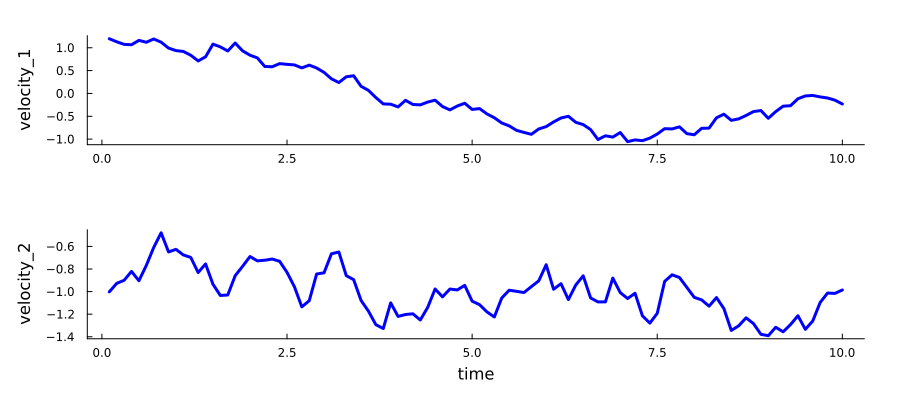

In [5]:
p1 = plot((1:T).*Δt, states[3,:], linewidth=3, color="blue", xlabel="", ylabel="velocity_1", label="")
p2 = plot((1:T).*Δt, states[4,:], linewidth=3, color="blue", xlabel="time", ylabel="velocity_2", label="")
plot(p1,p2, layout=(2,1), size=(900,400))

## Model

A Kalman filter is a special case of a larger class of Bayesian filters: it is the state estimator in linear Gaussian dynamical system where all parameters and coefficients are known (or fixed).

The system is captured by the following state-space model:

$$\begin{align}
p(x_k | x_{k-1}) &= \mathcal{N}(x_k | Ax_{k-1}, Q) \\
p(y_k | x_k) &= \mathcal{N}(y_k | Cx_{k-1}, R) \, .
\end{align}$$

With a Gaussian prior distribution on the initial state:

$$p(x_0) = \mathcal{N}(x_0 | m_0, P_0) \, .$$

## Inference

then we can obtain a posterior recursively through the Bayesian filtering equations. The update and correction steps at each time point are:

$$\begin{align}
p(x_k | y_{1:k-1}) &= \int p(x_k | x_{k-1}) p(x_{k-1} | y_{1:k-1}) dx_{k-1} \\
p(x_k | y_{1:k}) &= \frac{1}{p(y_k | y_{1:k-1})} p(y_k | x_k) p(x_k | y_{1:k-1}) \, .
\end{align}$$

Using Gaussians, all these computations are tractable and we get the optimal state estimates in analytic form.

In [11]:
# State prior
x_0 = (zeros(Dx), diagm(ones(Dx)))

# Kalman filter
mx, Px = kalman_filter(observations, A, C, Q, R, x_0, time_horizon=T);

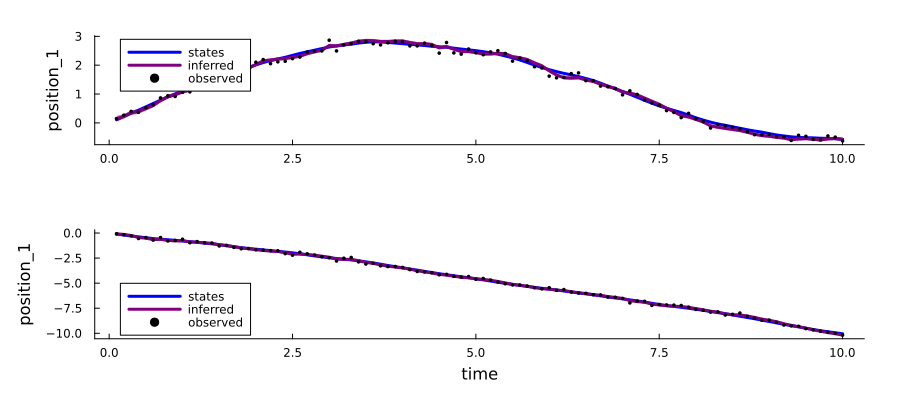

In [7]:
# Inspect data
p1 = plot((1:T).*Δt, states[1,:], linewidth=3, color="blue", xlabel="", ylabel="position_1", label="states", size=(700,400))
plot!((1:T).*Δt, mx[1,:], ribbon=sqrt.(Px[1,1,:]), linewidth=3, color="purple", label="inferred", ylabel="position_1", size=(700,400))
scatter!((1:T).*Δt, observations[1,:], color="black", markersize=2, label="observed", legend=:topleft)
p2 = plot((1:T).*Δt, states[2,:], linewidth=3, color="blue", xlabel="time", ylabel="position_2", label="states", size=(600,400))
plot!((1:T).*Δt, mx[2,:], ribbon=sqrt.(Px[2,2,:]), linewidth=3, color="purple", label="inferred", ylabel="position_1", size=(700,400))
scatter!((1:T).*Δt, observations[2,:], color="black", markersize=2, label="observed", legend=:bottomleft)
plot(p1,p2, layout=(2,1), size=(900,400))

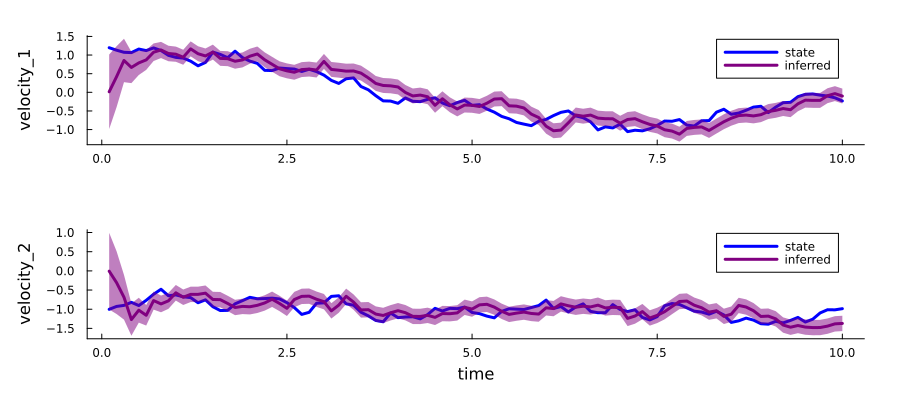

In [8]:
p1 = plot((1:T).*Δt, states[3,:], linewidth=3, color="blue", xlabel="", ylabel="velocity_1", label="state")
plot!((1:T).*Δt, mx[3,:], ribbon=sqrt.(Px[3,3,:]), linewidth=3, color="purple", label="inferred")
p2 = plot((1:T).*Δt, states[4,:], linewidth=3, color="blue", xlabel="time", ylabel="velocity_2", label="state")
plot!((1:T).*Δt, mx[4,:], ribbon=sqrt.(Px[4,4,:]), linewidth=3, color="purple", label="inferred")

plot(p1,p2, layout=(2,1), size=(900,400))